Intentando cargar desde URL: https://raw.githubusercontent.com/alura-cursos/challenge2-data-science-LATAM/main/data/telecom_users.csv
Intentando cargar desde URL: https://raw.githubusercontent.com/sthemonica/alura-voz/refs/heads/main/Dados/Telco-Customer-Churn.json
✅ Dataset cargado con éxito. Filas, columnas: (7267, 6)

--- Vista rápida
   customerID Churn                                           customer  \
0  0002-ORFBO    No  {'gender': 'Female', 'SeniorCitizen': 0, 'Part...   
1  0003-MKNFE    No  {'gender': 'Male', 'SeniorCitizen': 0, 'Partne...   
2  0004-TLHLJ   Yes  {'gender': 'Male', 'SeniorCitizen': 0, 'Partne...   
3  0011-IGKFF   Yes  {'gender': 'Male', 'SeniorCitizen': 1, 'Partne...   
4  0013-EXCHZ   Yes  {'gender': 'Female', 'SeniorCitizen': 1, 'Part...   

                                             phone  \
0   {'PhoneService': 'Yes', 'MultipleLines': 'No'}   
1  {'PhoneService': 'Yes', 'MultipleLines': 'Yes'}   
2   {'PhoneService': 'Yes', 'MultipleLines': 'No'}   

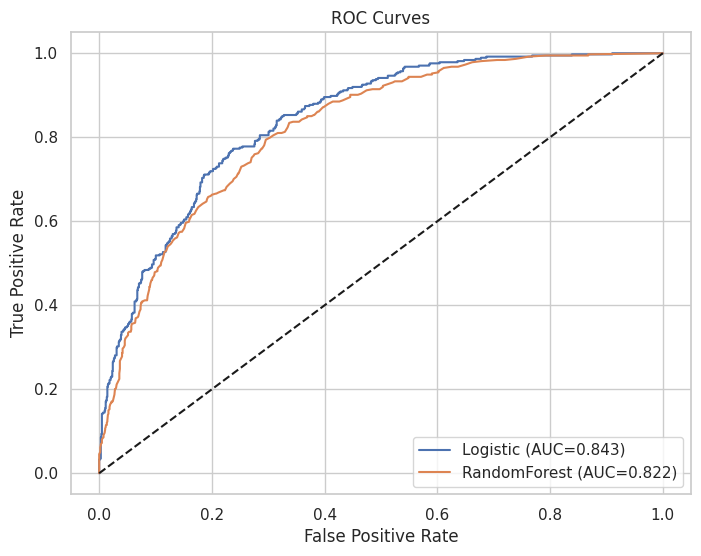


Top 15 features - Random Forest:
                                   feature  importance
0                            account_total    0.161936
1                          customer_tenure    0.144341
2                          account_monthly    0.132624
3          account_contract_Month-to-month    0.051045
4               internet_onlinesecurity_No    0.032168
5   account_paymentmethod_Electronic check    0.029660
6                  internet_techsupport_No    0.028710
7     internet_internetservice_Fiber optic    0.024499
8                   customer_seniorcitizen    0.019033
9                account_contract_Two year    0.018223
10                  customer_gender_Female    0.017921
11                internet_onlinebackup_No    0.017705
12                    customer_gender_Male    0.017430
13            internet_deviceprotection_No    0.016078
14            account_paperlessbilling_Yes    0.015357


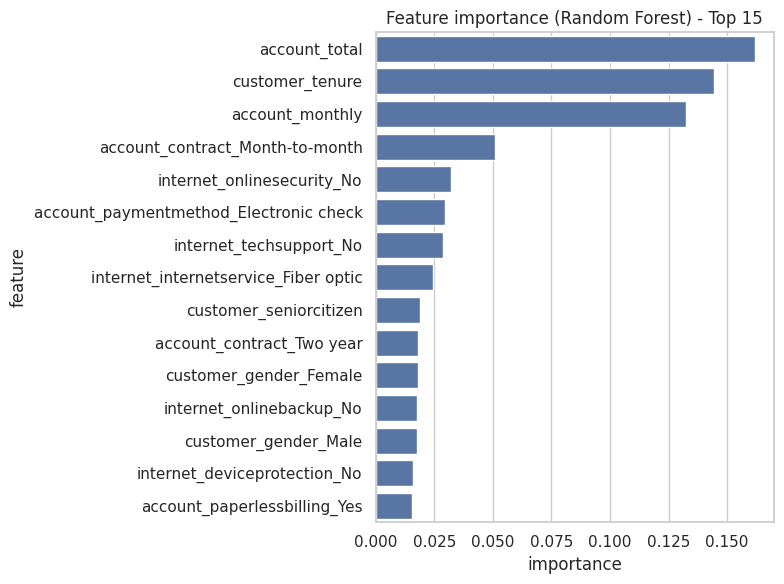


Top 15 features por valor absoluto de coeficiente (Logistic):
                                            feature      coef  abs_coef
0                                   customer_tenure -1.389330  1.389330
1                         account_contract_Two year -0.765773  0.765773
2                                     account_total  0.658152  0.658152
3                   account_contract_Month-to-month  0.583023  0.583023
4                      internet_internetservice_DSL -0.361606  0.361606
5                            phone_phoneservice_Yes -0.334979  0.334979
6                       account_paperlessbilling_No -0.328118  0.328118
7                            phone_multiplelines_No -0.306570  0.306570
8                          internet_techsupport_Yes -0.302927  0.302927
9                       internet_onlinesecurity_Yes -0.256976  0.256976
10           account_paymentmethod_Electronic check  0.221141  0.221141
11                          customer_dependents_Yes -0.220329  0.220329
1

In [1]:
"""
TelecomX - Parte 2: Pipeline de modelado (Regresión Logística + Random Forest)
Archivo listo para ejecutar en Google Colab o Jupyter.

Instrucciones rápidas:
- Si estás en Colab: sube `telecom_users.csv` a la izquierda (Files → Upload) o ejecuta la celda de upload incluida.
- Ejecuta las celdas en orden. Lee los comentarios para entender qué hace cada bloque.

Salida esperada: train/test split, métricas de evaluación para ambos modelos, gráfico ROC, importancia de features.

Autor: Beatriz
"""

# %%
# 1) IMPORTS Y CONFIG
import os
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (classification_report, confusion_matrix,
                             roc_auc_score, roc_curve, accuracy_score)

# %%
# 2) CARGAR DATOS
# - Intenta leer un archivo local llamado 'telecom_users.csv'
# - Si estás en Colab y no lo subiste, usa la celda de upload (ver más abajo)

def load_data_try_local():
    candidates = [
        'telecom_users.csv',
        '/content/telecom_users.csv',
        'data/telecom_users.csv'
    ]
    for p in candidates:
        if os.path.exists(p):
            print(f"Leyendo {p}")
            # Intentamos autodetectar separador; primero coma, si falla probamos ;
            try:
                return pd.read_csv(p)
            except Exception:
                return pd.read_csv(p, sep=';')
    return None

# Si estás en Colab y aun no subiste, descomenta el siguiente bloque para subir manualmente
# from google.colab import files
# uploaded = files.upload()
# # uploaded es un dict; si subiste telecom_users.csv, pandas podrá leerlo directamente

# Intento de carga local
df = load_data_try_local()

# Si no estaba en el entorno local, tratamos algunas URL conocidas como fallback (opcional)
if df is None:
    possible_urls = [
        'https://raw.githubusercontent.com/alura-cursos/challenge2-data-science-LATAM/main/data/telecom_users.csv',
        'https://raw.githubusercontent.com/sthemonica/alura-voz/refs/heads/main/Dados/Telco-Customer-Churn.json'
    ]
    for url in possible_urls:
        try:
            print('Intentando cargar desde URL:', url)
            if url.lower().endswith('.csv'):
                df = pd.read_csv(url)
            else:
                df = pd.read_json(url)
            break
        except Exception as e:
            df = None

if df is None:
    raise FileNotFoundError("No pude encontrar 'telecom_users.csv' en el entorno ni cargarlo desde las URLs. Sube el archivo a Colab y vuelve a ejecutar.")

print('✅ Dataset cargado con éxito. Filas, columnas:', df.shape)

# %%
# 3) VISTA RÁPIDA
print('\n--- Vista rápida')
print(df.head(5))
print('\n--- Info:')
print(df.info())
print('\n--- Nulos por columna:')
print(df.isnull().sum())

# %%
# 4) LIMPIEZA Y NORMALIZACIÓN DE NOMBRES
# Unificamos nombres de columnas para facilitar el trabajo
orig_cols = df.columns.tolist()
new_cols = [c.strip().lower().replace(' ', '_').replace('.', '_') for c in orig_cols]
df.columns = new_cols
print('\nColumnas (normalizadas):', df.columns.tolist())

# Eliminar columnas innecesarias si existen (ej: unnamed: 0, customerid)
drop_cols = [c for c in df.columns if 'unnamed' in c or 'customerid' in c or c == 'customer_id' or c == 'id']
if drop_cols:
    print('Eliminando columnas:', drop_cols)
    df = df.drop(columns=drop_cols, errors='ignore')

# %%
# 5) DETECTAR COLUMNA TARGET 'churn' y estandarizar valores
# Buscamos una columna cuyo nombre contenga 'churn'
possible_target = [c for c in df.columns if 'churn' in c]
if not possible_target:
    raise ValueError('No se encontró columna con nombre que contenga "churn". Revisa el archivo.')

target_col = possible_target[0]
print('Columna objetivo detectada:', target_col)

# Normalizamos valores y mapeamos a 0/1
# Aceptamos: 'yes'/'no', 'true'/'false', 1/0, 'si'/'no' (español)
df[target_col] = df[target_col].astype(str).str.strip().str.lower()
map_dict = {'yes':1, 'si':1, 'sí':1, 'true':1, '1':1, 'y':1, 'no':0, 'false':0, '0':0, 'n':0}
df[target_col] = df[target_col].map(map_dict)

# Eliminamos filas donde no pudimos mapear la columna target
before = df.shape[0]
df = df.dropna(subset=[target_col])
after = df.shape[0]
print(f'Removidas {before-after} filas sin valor válido en target')
# Convertir a entero
df[target_col] = df[target_col].astype(int)

# %%
# 6) TRATAMIENTO DE COLUMNAS ANIDADAS Y NUMÉRICAS ESPECIALES
# Convertimos las columnas con diccionarios anidados en columnas separadas
nested_cols = ['customer', 'phone', 'internet', 'account']
for col in nested_cols:
    if col in df.columns:
        try:
            # Aplica pd.Series a cada elemento de la columna
            nested_df = df[col].apply(pd.Series)
            # Normaliza nombres de las nuevas columnas
            nested_df.columns = [f'{col}_{sub_col}'.lower().replace(' ', '_').replace('.', '_') for sub_col in nested_df.columns]
            # Elimina la columna original y concatena las nuevas
            df = pd.concat([df.drop(columns=[col]), nested_df], axis=1)
            print(f'✅ Columna "{col}" expandida.')
        except Exception as e:
            print(f'⚠️ Error al expandir columna "{col}": {e}')

# Handle the 'account_charges' column specifically
if 'account_charges' in df.columns:
    # Convert 'Monthly' and 'Total' charges to numeric, coercing errors
    df['account_monthly'] = pd.to_numeric(df['account_charges'].apply(lambda x: x.get('Monthly', np.nan)), errors='coerce')
    df['account_total'] = pd.to_numeric(df['account_charges'].apply(lambda x: x.get('Total', np.nan)), errors='coerce')
    df = df.drop(columns=['account_charges'])
    print('✅ Columna "account_charges" expandida y convertida a numérico.')


# Algunas versiones del dataset tienen 'totalcharges' como string; lo convertimos
if 'totalcharges' in df.columns:
    df['totalcharges'] = pd.to_numeric(df['totalcharges'], errors='coerce')

# Revisamos nulos de nuevo y decidimos estrategia simple
print('\nNulos después de primeras conversiones y expansión:')
print(df.isnull().sum())

# %%
# 7) DEFINIR FEATURES (X) y TARGET (y)
# Evitamos columnas obvias irrelevantes (fechas, identificadores). Ya eliminamos customerid arriba.
X = df.drop(columns=[target_col])
y = df[target_col]

# Determinar columnas numéricas y categóricas
numeric_features = X.select_dtypes(include=['int64','float64']).columns.tolist()
cat_features = [c for c in X.columns if c not in numeric_features]

print('\nFeatures numéricas:', numeric_features)
print('Features categóricas:', cat_features)

# %%
# 8) SPLIT TRAIN / TEST
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print('\nSplit hecho:')
print('X_train:', X_train.shape, 'y_train:', y_train.shape)
print('X_test:', X_test.shape, 'y_test:', y_test.shape)

# %%
# 9) PREPROCESSING: Pipelines para numéricas y categóricas
numeric_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_pipeline, numeric_features),
    ('cat', categorical_pipeline, cat_features)
])

# %%
# 10) MODELOS: Pipelines completos
pipe_log = Pipeline(steps=[('preprocessor', preprocessor), ('clf', LogisticRegression(max_iter=1000))])
pipe_rf = Pipeline(steps=[('preprocessor', preprocessor), ('clf', RandomForestClassifier(n_estimators=200, random_state=42))])

# Entrenamos
print('\nEntrenando Regresión Logística...')
pipe_log.fit(X_train, y_train)
print('OK')

print('\nEntrenando Random Forest...')
pipe_rf.fit(X_train, y_train)
print('OK')

# %%
# 11) EVALUACIÓN: función utilitaria para mostrar métricas

def evaluate_model(pipe, X_test, y_test, name='model'):
    y_pred = pipe.predict(X_test)
    y_proba = None
    try:
        y_proba = pipe.predict_proba(X_test)[:, 1]
    except Exception:
        pass

    print(f"\n--- Reporte: {name} ---")
    print('Accuracy:', accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    print('Matriz de confusión:\n', confusion_matrix(y_test, y_pred))
    if y_proba is not None:
        print('ROC-AUC:', roc_auc_score(y_test, y_proba))
    return y_pred, y_proba

# Evaluar ambos
y_pred_log, y_proba_log = evaluate_model(pipe_log, X_test, y_test, 'Logistic Regression')
y_pred_rf, y_proba_rf = evaluate_model(pipe_rf, X_test, y_test, 'Random Forest')

# %%
# 12) ROC curves
plt.figure(figsize=(8,6))
if y_proba_log is not None:
    fpr, tpr, _ = roc_curve(y_test, y_proba_log)
    plt.plot(fpr, tpr, label=f'Logistic (AUC={roc_auc_score(y_test, y_proba_log):.3f})')
if y_proba_rf is not None:
    fpr, tpr, _ = roc_curve(y_test, y_proba_rf)
    plt.plot(fpr, tpr, label=f'RandomForest (AUC={roc_auc_score(y_test, y_proba_rf):.3f})')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.show()

# %%
# 13) IMPORTANCIA DE FEATURES - Random Forest
# Necesitamos recuperar los nombres de features después del preprocessor

def get_feature_names_from_preprocessor(preprocessor, numeric_features, categorical_features):
    # nombres numéricos: se mantienen
    num_feats = numeric_features
    # nombres categoricos: deben venir del OneHotEncoder
    cat_transformer = preprocessor.named_transformers_['cat']
    ohe = cat_transformer.named_steps['onehot']
    try:
        ohe_feats = list(ohe.get_feature_names_out(categorical_features))
    except Exception:
        # For older versions of sklearn
        ohe_feats = ohe.get_feature_names(categorical_features)
    return num_feats + list(ohe_feats)

feature_names = get_feature_names_from_preprocessor(preprocessor, numeric_features, cat_features)


if hasattr(pipe_rf.named_steps['clf'], 'feature_importances_') and feature_names:
    importances = pipe_rf.named_steps['clf'].feature_importances_
    fi = pd.DataFrame({'feature': feature_names, 'importance': importances})
    fi = fi.sort_values('importance', ascending=False).reset_index(drop=True)
    print('\nTop 15 features - Random Forest:')
    print(fi.head(15))
    # Gráfico
    plt.figure(figsize=(8,6))
    sns.barplot(data=fi.head(15), x='importance', y='feature')
    plt.title('Feature importance (Random Forest) - Top 15')
    plt.tight_layout()
    plt.show()
else:
    print('No fue posible extraer importancia de features (¿faltan features categóricas?).')

# %%
# 14) COEFICIENTES - Regresión Logística (interpretabilidad)
if hasattr(pipe_log.named_steps['clf'], 'coef_') and feature_names:
    coefs = pipe_log.named_steps['clf'].coef_[0]
    coef_df = pd.DataFrame({'feature': feature_names, 'coef': coefs})
    coef_df['abs_coef'] = coef_df['coef'].abs()
    coef_df = coef_df.sort_values('abs_coef', ascending=False).reset_index(drop=True)
    print('\nTop 15 features por valor absoluto de coeficiente (Logistic):')
    print(coef_df.head(15))
else:
    print('No se pudieron obtener coeficientes de la regresión logística.')

# %%
# 15) Guardar modelos y resultados (opcional)
# Si querés guardar los modelos para usarlos luego, descomenta
# import joblib
# joblib.dump(pipe_log, 'pipe_logistic.pkl')
# joblib.dump(pipe_rf, 'pipe_rf.pkl')

print('\n¡Pipeline finalizado! Revisa las métricas y las importancias para sacar conclusiones.')

                                           Variable  Importancia
3                                     account_total     0.161936
1                                   customer_tenure     0.144341
2                                   account_monthly     0.132624
36                  account_contract_Month-to-month     0.051045
18                       internet_onlinesecurity_No     0.032168
43           account_paymentmethod_Electronic check     0.029660
27                          internet_techsupport_No     0.028710
16             internet_internetservice_Fiber optic     0.024499
0                            customer_seniorcitizen     0.019033
38                        account_contract_Two year     0.018223
4                            customer_gender_Female     0.017921
21                         internet_onlinebackup_No     0.017705
5                              customer_gender_Male     0.017430
24                     internet_deviceprotection_No     0.016078
40                     ac

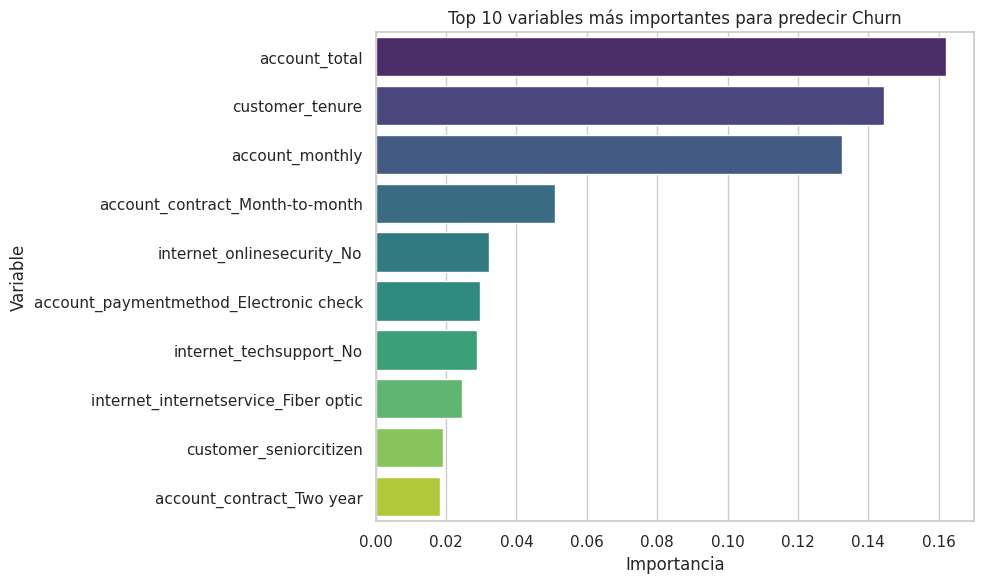

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Importancia de las variables del mejor modelo
# Access the trained Random Forest classifier from the pipeline
modelo_rf = pipe_rf.named_steps['clf']
importancias = modelo_rf.feature_importances_
# Use feature names after preprocessing
caracteristicas = feature_names

# Crear DataFrame ordenado
df_importancia = pd.DataFrame({
    'Variable': caracteristicas,
    'Importancia': importancias
}).sort_values(by='Importancia', ascending=False)

# Mostrar tabla
print(df_importancia)

# Gráfico de importancia
plt.figure(figsize=(10, 6))
sns.barplot(data=df_importancia.head(10), x='Importancia', y='Variable', palette='viridis')
plt.title('Top 10 variables más importantes para predecir Churn')
plt.xlabel('Importancia')
plt.ylabel('Variable')
plt.tight_layout()
plt.show()

#Importancia de las variables
## Esto muestra las variables ordenadas de menor a mayor importancia, en un gráfico horizontal.

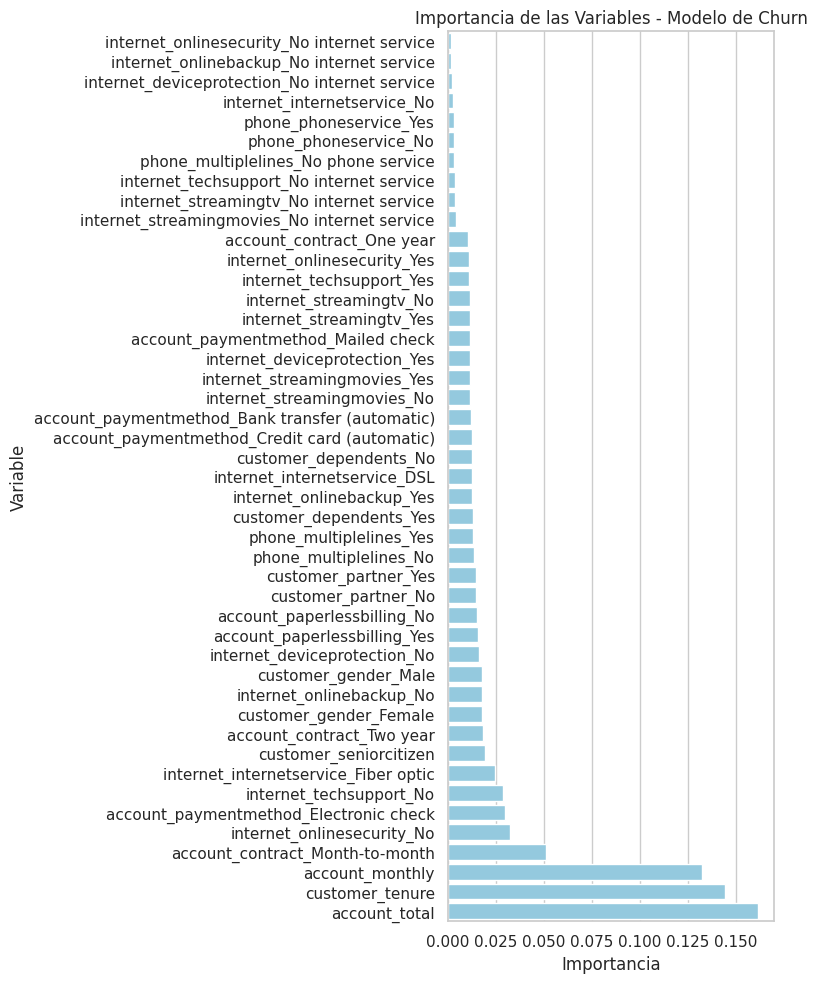

In [3]:
import matplotlib.pyplot as plt

# Ordenar por importancia descendente
importances_sorted = df_importancia.sort_values(by="Importancia", ascending=True)

# Graficar
plt.figure(figsize=(8, 10))
sns.barplot(data=importances_sorted, x="Importancia", y="Variable", color="skyblue")
plt.xlabel("Importancia")
plt.ylabel("Variable")
plt.title("Importancia de las Variables - Modelo de Churn")
plt.tight_layout()
plt.show()


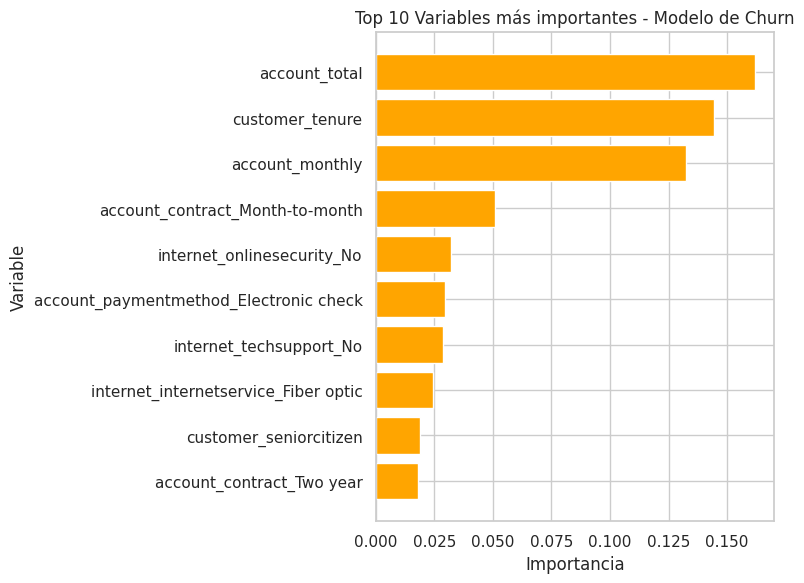

In [4]:
# Mostarndo las 10 más importantes
# Top 10 variables
top_10 = df_importancia.sort_values(by="Importancia", ascending=True).tail(10)

plt.figure(figsize=(8, 6))
plt.barh(top_10["Variable"], top_10["Importancia"], color="orange")
plt.xlabel("Importancia")
plt.ylabel("Variable")
plt.title("Top 10 Variables más importantes - Modelo de Churn")
plt.tight_layout()
plt.show()

# Estrategia sugerida

📌 Estrategia Sugerida

1. **Fomentar contratos de largo plazo**  
   Los contratos mensuales tienen mayor riesgo de cancelación. Implementar descuentos o beneficios exclusivos para planes anuales o bianuales.

2. **Incentivar la permanencia de nuevos clientes**  
   Los clientes con menor tiempo en la compañía presentan mayor tasa de cancelación. Se pueden ofrecer bonos, promociones o atención personalizada durante los primeros meses.

3. **Mejorar la experiencia de pago**  
   Los clientes que usan 'Electronic check' muestran mayor propensión a cancelar. Se recomienda fomentar medios automáticos como tarjeta de crédito o débito automático.

4. **Promover servicios de valor agregado**  
   Servicios como seguridad online, soporte técnico y protección de dispositivos reducen la cancelación. Ofrecer paquetes combinados o periodos de prueba gratuitos puede aumentar la retención.

5. **Monitoreo y segmentación preventiva**  
   Usar el modelo predictivo para identificar clientes con alto riesgo y contactarlos proactivamente con ofertas y soluciones personalizadas.




## 📊 Resumen de Hallazgos Clave

- **Factores más influyentes**: El monto total facturado, el tiempo de permanencia y la tarifa mensual son las variables con mayor peso en la predicción de cancelación.
- **Mayor riesgo de cancelación**: Clientes con contratos mes a mes y pagos por cheque electrónico muestran tasas de churn significativamente más altas.
- **Protecciones asociadas a menor churn**: Contar con seguridad en línea, soporte técnico y protección de dispositivos reduce notablemente la probabilidad de cancelación.
- **Segmento prioritario para retención**: Clientes nuevos que contratan fibra óptica bajo contratos flexibles son un grupo crítico a abordar.

💡 **Recomendación**: Implementar estrategias de fidelización dirigidas a clientes con contratos mensuales y alto valor de facturación, ofreciendo beneficios o descuentos para migrar a planes anuales o bianuales, junto con paquetes que incluyan servicios de protección y soporte.




## ✅ Conclusión Final

El modelo desarrollado permitió identificar con claridad los factores que más influyen en la cancelación de clientes en **Telecom X**.  
Variables como el **monto total facturado**, el **tiempo de permanencia** y la **tarifa mensual** resultaron ser determinantes para predecir el churn.  
Asimismo, se detectó que los clientes con **contratos mensuales** y **pago por cheque electrónico** presentan un riesgo considerablemente mayor de baja.

A partir de estos hallazgos, se recomienda implementar estrategias de retención focalizadas, como ofrecer incentivos para migrar a contratos de largo plazo, incluir beneficios adicionales para servicios con fibra óptica y reforzar el soporte técnico y las protecciones de seguridad en línea.

Con estas acciones, la empresa podrá anticiparse a la cancelación y optimizar sus esfuerzos de fidelización, maximizando la retención de clientes y la rentabilidad a largo plazo.
